In [1]:
import random 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import math
import time

###### ゲートやエラーの定義 #####
#エラーの定義
def x_error(qubit,i):
    qubit[0][i] ^= 1
def y_error(qubit,i):
    qubit[0][i] ^= 1    
    qubit[1][i] ^= 1
def z_error(qubit,i):
    qubit[1][i] ^=  1 

def single_biased(qubit,i,p,eta): # etaはバイアス
    p_x = p / (2*(eta+1))
    p_z = p * eta / (eta+1) 
    prob = random.random() 
    if prob < p_z: #Z error
        z_error(qubit,i)
    elif prob < p_z+p_x: # X error
        x_error(qubit,i)
    elif prob < p_z+2*p_x: # Y error
        y_error(qubit,i)

def bitflip_error(qubit,i,p,eta): # etaはバイアス
    prob = random.random() 
    pp = p / (eta+1)
    if prob < pp: #Z error
        x_error(qubit,i)

def phaseflip_error(qubit,i,p,eta): # H後の測定でZエラー
    prob = random.random() 
    pp = p * (2*eta+1) / (2*(eta+1))
    if prob < pp: #Z error
        z_error(qubit,i)

# i番目にHadamard gateを作用させる
def H(qubit,i):
    qubit[0][i]^=qubit[1][i]
    qubit[1][i]^=qubit[0][i]
    qubit[0][i]^=qubit[1][i]

#i番目がcontrolビット j 番目がtargetビットのCNOTgate
def CNOT(qubit,c,t):
    qubit[0][t]^=qubit[0][c]
    qubit[1][c]^=qubit[1][t]

##### detection eventを作成する関数の定義 #####
def repetition(code_distance,rep,p,eta):
    nqubits = 2*code_distance-1
    qubit = [[0 for _ in range(nqubits)],[0 for _ in range(nqubits)]]

    D = np.zeros((code_distance-1,rep+2)) #シンドローム測定の回数+最初の状態のシンドローム+最後の測定から計算したシンドローム

    qubits_his = np.zeros((code_distance,rep+2))

    # 初期化のエラーなし
    ############  全てプラスに初期化  ##############
    # 測定を格納
    for i in range(code_distance-1):
        D[i][0] = qubit[1][2*i+1]   ### Zエラーがあるかは[1]
    for i in range(nqubits):
        if i % 2 == 0:
            #bitflip_error(qubit,i,p,eta) #状態準備のエラー
            H(qubit,i) 
            #single_biased(qubit,i,p,eta) # Hゲート後のエラー
    #############################################
    #print(qubit)
    #############  ループ部分  ##################
    for num in range(rep):

        ### 履歴に格納
        for i in range(code_distance):
            qubits_his[i][num+1] = qubit[1][2*i]

        # シンドローム測定のための初期化
        for i in range(code_distance-1):
            ### 初期化
            bitflip_error(qubit,2*i+1,p,eta)
            H(qubit,2*i+1)

        for i in range(nqubits-1):
            if i % 2 == 0:
                CNOT(qubit,i+1,i)
                single_biased(qubit,i,p,eta)
                single_biased(qubit,i+1,p,eta)
            if i % 2 == 1:
                CNOT(qubit,i,i+1)
                single_biased(qubit,i,p,eta)
                single_biased(qubit,i+1,p,eta)
        for i in range(nqubits):
            if i % 2 == 0:
                #single_biased(qubit,i,p,eta) #動的デカップリング部分
                continue

        # シンドローム測定
        for i in range(code_distance-1):
            H(qubit,2*i+1)
            single_biased(qubit,2*i+1,p,eta) # アダマール 
            bitflip_error(qubit,i,p,eta) # 測定エラー
            D[i][num+1] = qubit[0][2*i+1]            #######要変更
            qubit[0][2*i+1] = 0   #######要変更
            qubit[1][2*i+1] = 0    ### X測定ならこっち

    ############################################
    
    ##############  最後のデータビットを測定  ######
    result = [[],[]]
    for i in range(nqubits):
        if i % 2 == 0:
            H(qubit,i) 
            bitflip_error(qubit,i,p,eta) #測定前
            result[0].append(qubit[0][i])
            result[1].append(qubit[1][i])

    for i in range(code_distance):
        qubits_his[i][rep+1] = result[0][i]
    #############################################
    #print(qubit)
    # データからシンドローム求める
    for i in range(code_distance-1):
        D[i][rep+1] = (result[0][i]+result[0][i+1])%2

    # detection eventの行列
    E = np.zeros((code_distance-1,rep+1))
    for i in range(code_distance-1):
        for num in range(rep+1):
            E[i,num] = (D[i,num] + D[i,num+1]) % 2

    #print("D= ", D.T)
    #print(result)
    #print("E= ", E.T)

    count_x = 0
    count_z = 0
    # 差分シンドロームが1のところは座標のデータを格納する
    edge_of_decoder_graph = []
    for i in range(code_distance-1):
        for num in range(rep+1):
            if E[i,num] == 1:
                edge_of_decoder_graph.append((i,num))
                
    ### 最小距離のグラフの作成
    gp = nx.Graph()
    # 頂点の追加
    p_z = p * eta/(eta+1)
    p_x = p * 1/(2*(eta+1))
    p_dephase = p_z + p_x
    p_flip = 2*p_x

    for i in range(code_distance-1):
        for num in range(rep+1):
            gp.add_node((i,num))
    # データ方向(exも同じ形になる)
    for i in range(code_distance-2):
        for num in range(rep+1):
            if num == 0:
                gp.add_edge((i,num),(i+1,num),weight=-math.log(p))
            elif num == rep:
                gp.add_edge((i,num),(i+1,num),weight=-math.log(p))
            else:
                gp.add_edge((i,num),(i+1,num),weight=-math.log(p))
    # 反復方向(測定ミス)
    for i in range(code_distance-1):
        for num in range(rep):
            if num == rep:
                continue
            else:
                gp.add_edge((i,num),(i,num+1),weight=-math.log(p))
    # 斜め辺の追加(データ方向)
    for i in range(code_distance-2):
        for num in range(rep):
            gp.add_edge((i,num),(i+1,num+1),weight=-math.log(p))
    #正方格子に外点を1つ加えておく（単点ではパリティを検出できないため、パリティoddになる頂点数が奇数になりうる）
    gp.add_node('external')
    for num in range(rep+1):
        if num == 0:
            gp.add_edge('external',(0,num),weight=-math.log(p))
            gp.add_edge('external',(code_distance-2,num),weight=-math.log(p))
        elif num == rep:
            gp.add_edge('external',(0,num),weight=-math.log(p))
            gp.add_edge('external',(code_distance-2,num),weight=-math.log(p))
        else:
            gp.add_edge('external',(0,num),weight=-math.log(p))
            gp.add_edge('external',(code_distance-2,num),weight=-math.log(p))

    #パリティoddの頂点数が奇数の場合は外点をdecoer graphに追加して頂点数を偶数に
    if len(edge_of_decoder_graph)%2==1:
        edge_of_decoder_graph.append('external')
    mwpm_gp = nx.Graph()
    for i in range(len(edge_of_decoder_graph)):
            mwpm_gp.add_node(i)
    for i in range(len(edge_of_decoder_graph)):
        for j in range(i):
            shortest_path_weight = nx.dijkstra_path_length(gp, edge_of_decoder_graph[i],edge_of_decoder_graph[j])
            mwpm_gp.add_edge(i,j,weight = 100000000000 - shortest_path_weight)
    mwpm_res = nx.max_weight_matching(mwpm_gp)
    match_path = []
    for match_pair in mwpm_res:
        match_path.append(nx.dijkstra_path(gp,edge_of_decoder_graph[match_pair[0]],edge_of_decoder_graph[match_pair[1]]))
    ##print(match_path)

    for path in match_path:
        for i in range(len(path)): 
            if i !=0: #i=0は飛ばす
                if path[i-1] == 'external': # 左='external'
                    if path[i][0] == 0: #上側エラーなら
                        result[0][0] ^= 1 #上端を反転　　#### Zの方を訂正するなら一つ目の[]は[1]
                    else: #右端エラーなら
                        result[0][code_distance-1]^= 1 #右端を反転
                        
                elif path[i] == 'external': # 右='external'
                    if path[i-1][0] == 0:
                        result[0][0]^= 1 #上端を反転
                    else:
                        result[0][code_distance-1]^= 1 #右端を反転
                
                elif path[i-1][1] == path[i][1]: #端のエラーではなく、同じサイクルでのエラーなら
                    result[0][min(path[i-1][0],path[i][0])+1] ^= 1
                
                elif path[i-1][0] == path[i][0]:
                    continue

                else:
                    result[0][min(path[i-1][0],path[i][0])+1]^= 1
    ### 論理エラーのカウント
    # Zエラー
    if result[0] != [0]*code_distance:
        count_z = 1
    # Xエラー
    if sum(result[1])%2 == 1:
        count_x = 1
    #print("result_X=",result[0],"result_Z=",result[1])

    dif_qubits_his = np.zeros((code_distance,rep+1))
    for num in range(rep+1):
        for i in range(code_distance):
            dif_qubits_his[i,num] = (qubits_his[i,num] + qubits_his[i,num+1])%2

    print(result)
    #print('error\n', np.flipud(qubits_his))
    #print('error\n', np.flipud(dif_qubits_his))
    #print('detection event\n', np.flipud(E))
    print(match_path)  
            
    fig, ax = plt.subplots(figsize=(6,8))
    #エラーの描写
    for num in range(rep+1):
        for i in range(code_distance):
            ax.plot(num,i,marker='o',color="b",markersize=10,markeredgewidth=2,markerfacecolor='w')
            if dif_qubits_his[i,num] == 1:
                X = []
                Y = []
                X.append(num)
                Y.append(i+1/2)
                X.append(num)
                Y.append(i-1/2)
                ax.plot(X,Y,color="b",lw=5)
                ax.plot(num,i,marker='o',color="b",markersize=10)
    #誤り訂正の描写
    for num in range(rep+1):
        for i in range(code_distance-1):
            if E[i][num] == 1:
                ax.plot(num+1/2,i+1/2,color="r",lw=3, marker='o',markersize=10)
    for path in match_path:
        for i in range(len(path)): 
            if i !=0: #i=0は飛ばす
                if path[i-1] == 'external': # 左='external'
                    if path[i][0] == 0: #上側エラーなら
                        X = [path[i][1]+1/2,path[i][1]+1/2]
                        Y = [float(path[i][0])+1/2,float(path[i][0])-1/2]
                        ax.plot(X,Y,color="r",lw=3)
                    else: #右端エラーなら
                        X = [path[i][1]+1/2,path[i][1]+1/2]
                        Y = [float(path[i][0])+3/2,float(path[i][0])+1/2]
                        ax.plot(X,Y,color="r",lw=3)
                        
                elif path[i] == 'external': # 右='external'
                    if path[i-1][0] == 0:
                        X = [path[i-1][1]+1/2,path[i-1][1]+1/2]
                        Y = [float(path[i-1][0])+1/2,float(path[i-1][0])-1/2]
                        ax.plot(X,Y,color="r",lw=3)
                    else:
                        X = [path[i-1][1]+1/2,path[i-1][1]+1/2]
                        Y = [float(path[i-1][0])+3/2,float(path[i-1][0])+1/2]
                        ax.plot(X,Y,color="r",lw=3)
                
                elif path[i-1][1] == path[i][1]: #端のエラーではなく、同じサイクルでのエラーなら
                    X = [path[i][1]+1/2,path[i][1]+1/2]
                    Y = [float(min(path[i][0],path[i-1][0]))+3/2,float(min(path[i][0],path[i-1][0]))+1/2]
                    ax.plot(X,Y,color="r",lw=3)
                
                elif path[i-1][0] == path[i][0]:
                    X = [min(path[i][1],path[i-1][1])+1/2,min(path[i][1],path[i-1][1])+1+1/2]
                    Y = [float(path[i-1][0])+1/2,float(path[i-1][0])+1/2]
                    ax.plot(X,Y,color="r",lw=3)

                else:
                    #result[0][min(path[i-1][0],path[i][0])+1]^= 1
                    X = [min(path[i][1],path[i-1][1])+1/2,min(path[i][1],path[i-1][1])+1+1/2]
                    Y = [float(min(path[i][0],path[i-1][0]))+1/2,float(min(path[i][0],path[i-1][0]))+3/2]
                    ax.plot(X,Y,color="r",lw=3)
    
    ax.set_xticks(list(range(rep+1)))
    ax.set_yticks(list(range(code_distance)))
    ax.set_xlim(-0.3,rep+0.8)
    ax.set_ylim(-0.8,code_distance-0.2)
    ax.grid()
    plt.show()    

    return count_x, count_z


#### 実行条件 ####

###### 実行
def implement(code_distance_list,rep_list,p,eta,ex_num):
    count = np.zeros((2*len(rep_list),len(code_distance_list)))
    for i in rep_list:
        for _ in range(ex_num):
            for cd in code_distance_list:
                count_x, count_z = repetition(cd,i,p,eta)
                count[2*(i-rep_list[0]),int((cd-code_distance_list[0])/2)] += count_x
                count[2*(i-rep_list[0])+1,int((cd-code_distance_list[0])/2)] += count_z
    count /= ex_num

    return count

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
[[(0, 2), (0, 3)], [(0, 1), (1, 1)], [(5, 3), (4, 2)], [(4, 3), (3, 2)], [(5, 0), 'external'], [(1, 0), (2, 1)]]


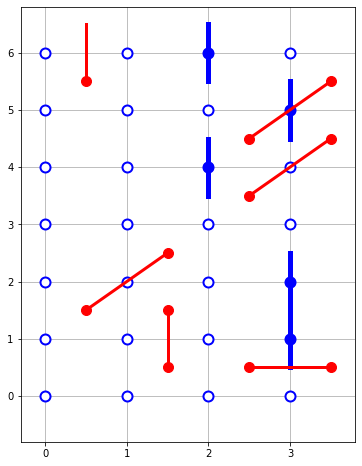

array([[0.],
       [0.]])

In [6]:
### パラメータ
code_distance=[7]
rep_list= list(range(3,4))
p=0.05
eta=1000
ex_num=1

implement(code_distance,rep_list,p,eta,ex_num)